# SMO Simple
The "Simple" means randomly choose lagrange complixier $\alpha_i$ and $\alpha_j$

In [1]:
import numpy as np
import pylab
import matplotlib.patches as mpatches
import random


pylab.ion()

Synthesised data -- decision boundary:

$x + 0.3 y = 0.1$

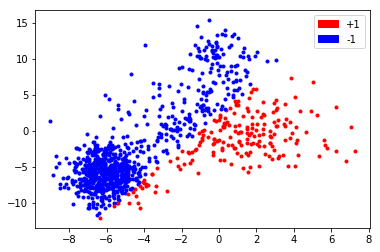

In [2]:
xa = np.random.randn(100, 2)
xb = np.random.randn(600, 2)
xc = np.random.randn(300, 2)
xa[:, 1] = xa[:, 1] * 3 + 9
xb[:, 0] = xb[:, 0] * 1 - 6
xb[:, 1] = xb[:, 1] * 2 - 6
xc = xc * 3
x = np.vstack([xa,xb,xc])
y = np.array(list(map(lambda x: 1 if x.dot(np.array([9, -4])) + 9 > 0 else -1, x)))
NUM_CLASSIFY = 2
NUM_DATA = 1000
C = 0
i, j = 0, 1

for i, j in zip(x, y):
    pylab.plot(i[0], i[1], '.', color='r' if j > 0 else 'b')
patch1 = mpatches.Patch(color='r', label='+1')
patch2 = mpatches.Patch(color='b', label='-1')
pylab.legend(handles=[patch1, patch2])

# SMO

## Optimize $a_j$

$a_j := aj - \frac{y^{(j)}(E_i-E_j)}{\eta}$

where

$E_k = f(x^{(k)}) - y^{(k)}$

$\eta = 2 x^{(i)}\bullet x^{(j)} - x^{(i)}\bullet x^{(i)} - x^{(j)}\bullet x^{(j)} $

## Clip $a_j$

$If y^{(i)} \neq y^{(j)}$, $L=max(0, a_j - a_i)$, $H = min(C, C + a_j - a_i)$

$If y^{(i)} = y^{(j)}$, $L=max(0, a_i + a_j - C)$, $H = min(C, a_i + a_j)$

## $a_i$
$a_i:=a_i+y^{(i)}y^{(j)}(a_j^{(old)}-a_j)$

## $b$
$b$ is optimized refering to Machine Learning (Zhou Zhihua, (6.18) P125), Where $S$ is subscript of support vector, and we choose the final $i$ and $j$.

$b = \frac{1}{|S|}\sum\limits_{s\in S}{(1/y_s-\sum\limits_{k\in S}\alpha_ky_k x_k \bullet x_s)}$

or

$b_1 = b - E_i - y{(i)}(\alpha_i - \alpha_i^{(old)})x^{(i)}\bullet x^{(i)} - y^{(j)}(\alpha_j-\alpha_j^{(old)}) x^{(i)}\bullet x^{(j)}$

$b_2 = b - E_j - y{(i)}(\alpha_i - \alpha_i^{(old)})x^{(i)}\bullet x^{(j)} - y^{(j)}(\alpha_j-\alpha_j^{(old)}) x^{(j)}\bullet x^{(j)}$

$b:=$

$b_1, if 0 < ai < C$

$b_2, if 0 < aj < C$

$(b_i + b_j) / 2, otherwise$

In [3]:
# INIT params
a = np.abs(np.random.randn(NUM_DATA))/100
b = np.random.randn()
i, j = 0, 1

def w(a, x, y):
    return np.sum(x.T * a * y, axis=1)

wij = w(a, x, y)

def f(w, xi, b):
    return w.dot(xi.T) + b

fi = f(wij, x[i], b)

def E(w, xi, b, yi):
    return f(w, xi, b) - yi

Ei, Ej = E(wij, x[i], b, y[i]), E(wij, x[j], b, y[j])

def eta(xi, xj):
    return 2 * xi.dot(xj) - xi.dot(xi) - xj.dot(xj)

etaij = eta(x[i], x[j])

def aj(aj0, eta, Ei, Ej, yj):
    return aj0 - yj * (Ei - Ej)/eta

ajj = aj(a[j], etaij, Ei, Ej, y[j])

def clipj(ajj, ai, aj, yi, yj, C=0):
    if yi != yj:
        L = max(0, aj - ai)
        H = min(C, C + aj - ai)
    else:
        L = max(0, ai + aj - C)
        H = min(C, ai + aj)
    return np.clip(ajj, L, H)

ajj = clipj(ajj, a[i], a[j], y[i], y[j], C)

def ai(ai0, yi, yj, aj0, aj):
    return ai0 + yi*yj*(aj0-aj)

aii = ai(a[i], y[i], y[j], a[j], ajj)

def b12(b, Ei, Ej, xi, xj, yi, yj, aii, ajj, ai0, aj0, C=0):
    b1 = b - Ei - yi * (aii - ai0) * (xi.dot(xi)) - yi*(ajj-aj0)*(xi.dot(xj))
    b2 = b - Ej - yi * (aii - ai0) * (xi.dot(xj)) - yj*(ajj-aj0)*(xj.dot(xj))
    c1 = 0 < aii < C
    c2 = 0 < ajj < C
    if c1 and not c2:
        return b1
    elif c2 and not c1:
        return b2
    else:
        return (b1 + b2) / 2

b = b12(b, Ei, Ej, x[i], x[j], y[i], y[j], aii, ajj, a[i], a[j], C)
a[i] = aii
a[j] = ajj

In [4]:
def update(i, j, a, b, x, y):
    wij = w(a, x, y)
    Ei, Ej = E(wij, x[i], b, y[i]), E(wij, x[j], b, y[j])
    etaij = eta(x[i], x[j])
    ajj = aj(a[j], etaij, Ei, Ej, y[j])
    ajj = clipj(ajj, a[i], a[j], y[i], y[j], C)
    aii = ai(a[i], y[i], y[j], a[j], ajj)
    
    b = b12(b, Ei, Ej, x[i], x[j], y[i], y[j], aii, ajj, a[i], a[j], C)
    a[i] = aii
    a[j] = ajj
    return a, b

In [5]:
def predict(a, b, x, y):
    return np.array(list(map(lambda x: 1 if x >0 else -1, f(w(a, x, y), x, b))))

def train(n_iter, a, b, x, y):
    population = range(NUM_DATA)
    for _ in range(n_iter):
        i, j = random.sample(population, 2)
        a, b = update(i, j, a, b, x, y)
        #print(np.sum(np.equal(predict(a, b, x, y), y)) / NUM_DATA, w(a, x, y), b)
    return a, b


0.964


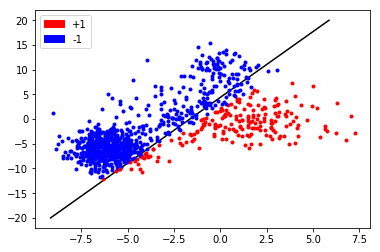

In [6]:
# INIT params
C=1
a = np.abs(np.random.randn(NUM_DATA))/100
b = 0#np.random.randn()
a, b = train(1000, a, b, x, y)

print(np.sum(np.equal(predict(a, b, x, y), y)) / NUM_DATA)
predict(a, b, x, y) 







w1, w2 = w(a, x, y)
threshold = 20
x0 = (-b - w2 * (-threshold))/w1
x1 = (-b - w2 * threshold)/w1
y0 = (-b - w1 * -threshold)/w2
y1 = (-b - w1 * threshold)/w2

if x0 < -threshold:
    xx1 = -threshold
    yy1 = y0
else:
    xx1 = x0
    yy1 = -threshold

if x1 > threshold:
    xx2 = threshold
    yy2 = y1
else:
    xx2 = x1
    yy2 = threshold
pylab.plot([xx1, xx2], [yy1, yy2], 'k', label='decision boundary')

for i, j in zip(x, y):
    pylab.plot(i[0], i[1], '.', color='r' if j > 0 else 'b')
patch1 = mpatches.Patch(color='r', label='+1')
patch2 = mpatches.Patch(color='b', label='-1')
pylab.legend(handles=[patch1, patch2])


In [7]:
print(w(a, x, y))
print(b)

[ 19.2305594   -7.21861262]
31.6032171919
